# DEEP CONVOLUTIONAL NEURAL NETWORK

This model has been entirely developed by Team 5, composed of Elisa, Joshua, and Paoloemilio. To build, train, test, and evaluate the model, we have adhered to the guidelines and best practices outlined in the following reference:

- Kapoor, A., Gulli, A., & Pal, S. (2019). *Deep Learning with TensorFlow 2 and Keras: Regression, ConvNets, GANs, RNNs, NLP, and more with TensorFlow 2 and the Keras API* (2nd ed.).

This notebook serves as an empirical application of the concepts and methodologies discussed in the book. It provides a comprehensive walkthrough of the entire process, showcasing our implementation and results.


In [82]:
#importing libraries
import tqdm
from tqdm import tqdm
import os
from PIL import Image
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

## MODEL BUILDING

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu',  kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [87]:
#compiling the model
OPTIM=Adam(learning_rate=0.001)

model.compile(optimizer= OPTIM, loss = 'categorical_crossentropy',
              metrics = [ "accuracy", 
                         Precision(name='precision'), 
                         Recall(name='recall'), 
                         AUC(name='auc')])

In [88]:
#display the model
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,563,908 (36.48 MB)

 Trainable params: 9,563,908 (36.48 MB)

 Non-trainable params: 0 (0.00 B)

## SPLITTING IN TRAIN AND TEST SET

This part of the code is only necessary if you're running the notebook for the first time. Be cautious: if you run this code more than once, you will duplicate the images, which will negatively impact the performance of the model.


In [112]:
base_dir = 'PUT DIRECTORY OF LABELLED IMAGES'
labels = ['advertisements', 'email', 'handwritten', 'resume']
file_paths = []
file_labels = []

# Create a list of file paths and labels
for label in labels:
    folder_path = os.path.join(base_dir, label)
    files = os.listdir(folder_path)
    for file in files:
        file_paths.append(os.path.join(folder_path, file))
        file_labels.append(label)

train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, 
    file_labels, 
    test_size=0.2, #You can change the percentage as you wish
    stratify=file_labels
)

def copy_files(file_paths, file_labels, dest_base_dir):
    for path, label in zip(file_paths, file_labels):
        dest_dir = os.path.join(dest_base_dir, label)
        if not os.path.exists(dest_dir):
            os.makedirs(dest_dir)
        shutil.copy(path, dest_dir)

# Define your new training and testing directories
train_dir = 'DEFINE THE PATH TO AN EMPTY DIRECTORY WHERE TO STORE TRAINING DATA'
test_dir = 'DEFINE THE PATH TO AN EMPTY DIRECTORY WHERE TO STORE TESTING DATA'

# Copy the files to the new directories
copy_files(train_paths, train_labels, train_dir)
copy_files(test_paths, test_labels, test_dir)

In [ ]:
def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

num_train_images = count_files(train_dir)
num_test_images = count_files(test_dir)

print(f"Total training images: {num_train_images}")
print(f"Total testing images: {num_test_images}")

## TRAINING THE MODEL

In [92]:
# Definining the callback
weights_dir ="CHOSE THE PATH WHERE TO STORE THE WEIGHTS"

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
best_model_file = os.path.join(weights_dir, "best_model.weights.h5")
checkpoint = ModelCheckpoint(best_model_file,
                             monitor='val_loss',
                             save_weights_only=True,
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
# Define the parameters for image data preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    validation_split=0.3, # better for consistency
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)
train_directory = 'PUT HERE THE PATH OF THE TRAINING DIRECTORY YOU ARE USING'

# Define the training generator
train_generator = datagen.flow_from_directory(
    directory=train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training'
)

# Define the validation generator
validation_generator = datagen.flow_from_directory(
    directory=train_directory,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation'
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

In [95]:
model.save("CNN_team5.h5")

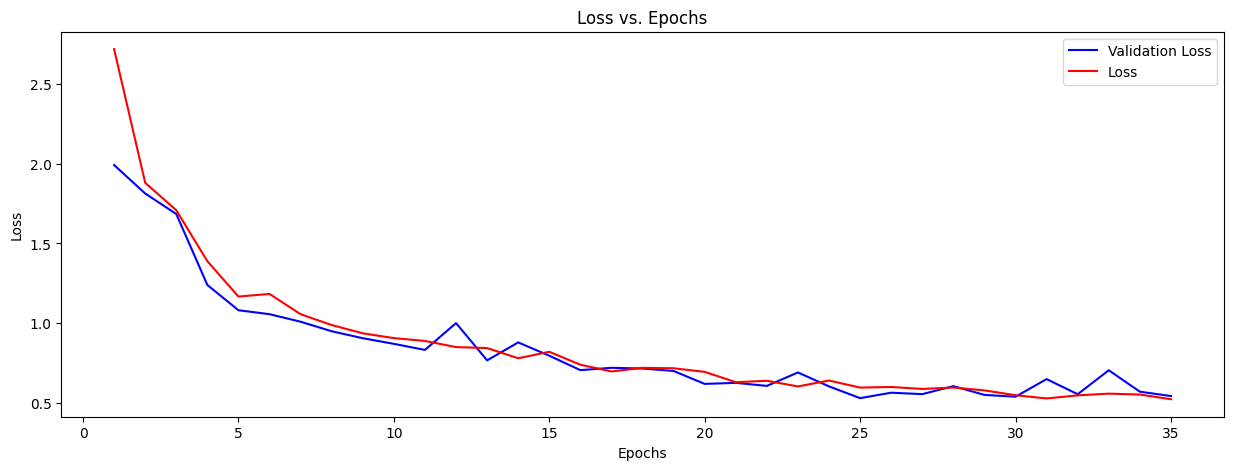

In [107]:
# LOSS PLOT
val_loss = history.history['val_loss']
loss = history.history['loss']

epochs = range(1, len(val_loss) + 1)

plt.figure(figsize=(15, 5))
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.plot(epochs, loss, 'r-', label='Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

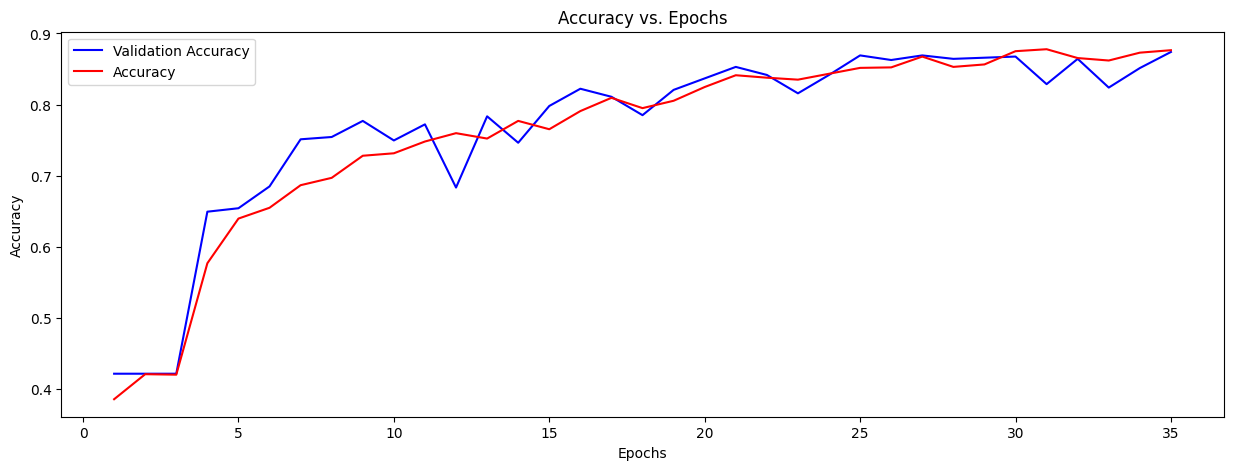

In [108]:
# ACCURACY PLOT
val_accuracy = history.history['val_accuracy']
accuracy = history.history['accuracy']

plt.figure(figsize=(15, 5))
plt.plot(epochs,val_accuracy , 'b-', label='Validation Accuracy')
plt.plot(epochs, accuracy, 'r-', label='Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

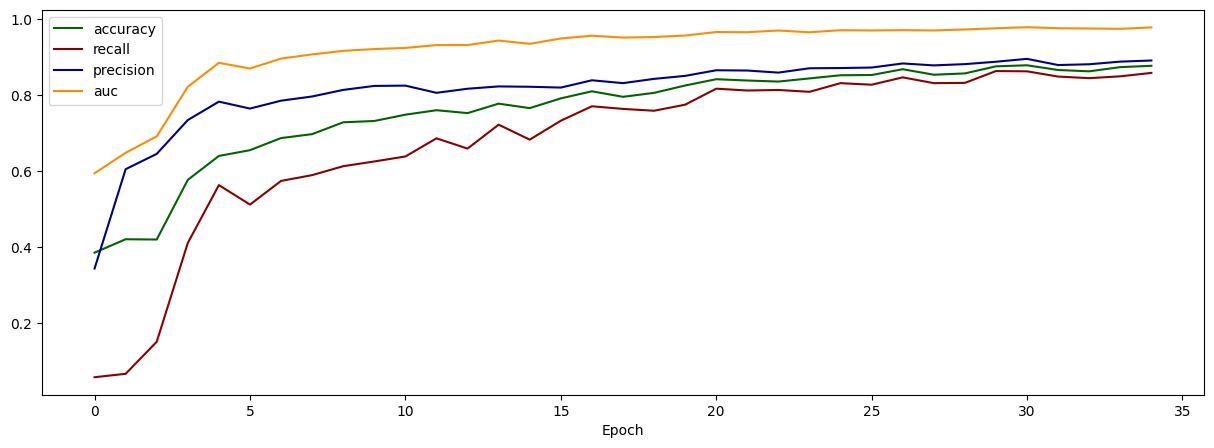

In [109]:
# PLOT OF THE ADDITIONAL METRICS USED: Accuracy, Recall, Precision, AUC

plt.figure(figsize = (15, 5))
plt.plot(history.history['accuracy'], "darkgreen", label= "accuracy")
plt.plot(history.history['recall'], "darkred", label= "recall")
plt.plot(history.history['precision'], "darkblue", label= "precision")
plt.plot(history.history['auc'], "darkorange", label= "auc")
plt.xlabel('Epoch')
plt.legend()

### Findings from the training

After extensive experimentation, the training process appears to be stable. There are no significant fluctuations in the metrics, and the training and validation curves follow the expected trends as outlined in the theory.


## MODEL EVALUATION

In [114]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

# Defining the parameter for test generator
test_generator = test_datagen.flow_from_directory(
    "PATH TO TEST DIRECTORY",
    target_size=(150, 150),
    batch_size=16,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False)

Found 433 images belonging to 4 classes.


In [116]:
# Evaluation of the model on the test set
results = model.evaluate(test_generator)
test_loss = results[0]
test_acc = results[1]
test_auc = results[2]

# Now, you can print them all
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
print(f"Test AUC: {test_auc}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8438 - auc: 0.9587 - loss: 0.6960 - precision: 0.8577 - recall: 0.8319
Test Loss: 0.6770642995834351
Test Accuracy: 0.8475750684738159
Test AUC: 0.8578199148178101


In [117]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

print(confusion_matrix(true_classes, predicted_classes))

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
[[ 74   0   1   1]
 [  4  41   4  21]
 [ 20   0  84   1]
 [ 11   0   3 168]]
                precision    recall  f1-score   support

advertisements       0.68      0.97      0.80        76
         email       1.00      0.59      0.74        70
   handwritten       0.91      0.80      0.85       105
        resume       0.88      0.92      0.90       182

      accuracy                           0.85       433
     macro avg       0.87      0.82      0.82       433
  weighted avg       0.87      0.85      0.85       433



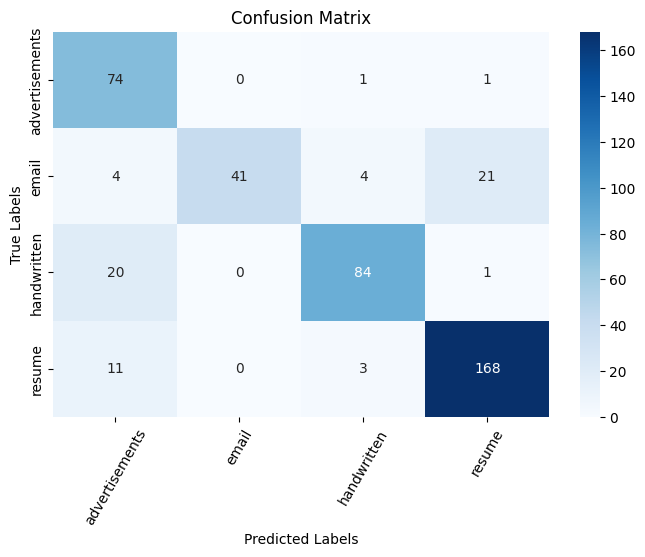

In [118]:
# PLOT THE CONFUSION MATRIX
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=60)
plt.show()

In [120]:
test_generator.reset()

# Predict the classes with the model
predictions = model.predict(test_generator, verbose=1)

predicted_classes_indices = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

count_true = np.sum(predicted_classes_indices == true_classes)
count_false = len(true_classes) - count_true

error_rate = count_false / len(true_classes)

print("Number of successes:", count_true)
print("Number of errors:", count_false)
print("Error rate:", error_rate)


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
Number of successes: 367
Number of errors: 66
Error rate: 0.15242494226327943


In [ ]:
# This code is used to display the predictions one by one in a big table
test_generator.shuffle = False
test_generator.batch_size = 1  # We want to see all the predictions one by one

test_generator.reset()

# If you want to test a subset, replace 'len(test_generator)' with the number of samples you want
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

predicted_classes_indices = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())

for i, (pred_idx, true_idx) in enumerate(zip(predicted_classes_indices, true_classes)):
    predicted_label = class_labels[pred_idx]
    true_label = class_labels[true_idx]
    
    result = "True" if predicted_label == true_label else "False"
    
    print(f"Prediction: {predicted_label} | Real class: {true_label} | Result: {result}")


433/433 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real class: advertisements | Result: True
Prediction: advertisements | Real cl

In [ ]:
# Sample display
test_generator.shuffle = False
test_generator.batch_size = 1
test_generator.reset()
predictions = model.predict(test_generator, steps=5)
predicted_classes_indices = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:5]
class_labels = list(test_generator.class_indices.keys())
for i in range(5):
    plt.figure(figsize=(5, 5))
    img = test_generator[i][0][0]
    predicted_label = class_labels[predicted_classes_indices[i]]
    true_label = class_labels[true_classes[i]]
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_label} | Actual: {true_label}')
    plt.axis('off')
    plt.show()